# Проект. A/B-тестирование

**Оглавление**:
1. [Описание проект](#task_definition)
2. [Предобработка данных](#data_preprocessing)
3. [Оценка корректности проведения теста](#correctness)
4. [Исследовательский анализ данных](#analysis)
5. [Оценка результатов теста](#ab_test)
6. [Выводы](#sum_up)

<a id="task_definition"></a>

## Описание проекта

**Цели исследования** — провести оценку результатов A/B-теста:
- Оценить корректность проведения теста:
  - проверить пересечение тестовой аудитории с конкурирующим тестом,
  - проверить совпадение теста и маркетинговых событий,
  - определить другие проблемы временных границ теста.
- Проанализировать результаты теста

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

<a id="data_preprocessing"></a>

## Предобработка данных

### Получение данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import math as mth
from scipy import stats as st

In [2]:
try:
    test_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
    users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

except FileNotFoundError:
    print('Файл не найден')
except FilePathError:
    print('Ошибка в названии пути')

In [3]:
k = 0
for i in (test_participants, users, events, marketing_events):
  names = ['test_participants', 'users', 'events', 'marketing_events']
  print('Название датасета:', names[k])
  print()
  print(i.info())
  print(i.head())
  print()
  k += 1

Название датасета: test_participants

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

Название датасета: users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      6173

### Типы данных

В нескольких датасетах мы видим столбцы, которые указывают на дату, но имеют неспецифичный тип - исправим эту неполадку. В остальных столбцах проблем нет.

In [4]:
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%dT%H:%M:%S')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')

### Пропуски

Проверим данные на наличие пропусков.

In [5]:
k = 0
for i in (test_participants, users, events, marketing_events):
  names = ['test_participants', 'users', 'events', 'marketing_events']
  print('Название датасета:', names[k])
  print()
  print(i.isna().sum())
  print()
  k += 1

Название датасета: test_participants

user_id    0
group      0
ab_test    0
dtype: int64

Название датасета: users

user_id       0
first_date    0
region        0
device        0
dtype: int64

Название датасета: events

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Название датасета: marketing_events

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64



Итак, пропуски обнаружились в столбце `details` датасета `events`. Стоит разобраться в их природе, возможно, их не стоит устранять.

In [6]:
events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [7]:
events[~events['details'].isna()]['event_name'].unique()

array(['purchase'], dtype=object)

In [8]:
events[events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Мы видим, что пропуски имеются только в тех случаях, когда `event_name` не является `purchase` (покупкой). Как мы знаем из описания, в столбце `details` хранится стоимость покупки в долларах, а значит природа всех остальных пропусков совершенно безобидна.

### Дубликаты

Проверим наши данные на явные дубликаты. Содержимое отдельных колонок выглядит единообразно и ручной ввод отсутствует, поэтому нет смысла переводить всё к единому регистру.

In [9]:
k = 0
for i in (test_participants, users, events, marketing_events):
  names = ['test_participants', 'users', 'events', 'marketing_events']
  print('Название датасета:', names[k])
  print()
  print(i.duplicated().sum())
  print()
  k += 1

Название датасета: test_participants

0

Название датасета: users

0

Название датасета: events

0

Название датасета: marketing_events

0



Дубликатов не обнаружено.

### Категориальные данные

In [10]:
test_participants[test_participants['group'] != 'C']['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В нашем датасете есть информация о 2 тестах: 'recommender_system_test' и 'interface_eu_test'.

In [11]:
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

В датасете есть информация о пользователях из 4 регионов: EU (Европа), N.America (Северная Америка), CIS (СНГ) и APAC (Азиатско-Тихоокеанский регион).

In [12]:
users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Есть информация об устройствах пользователей, их всего 4: PC, Android, iPhone, Mac.

In [13]:
print('Общее количество праздников в датасете marketing_events:', marketing_events['name'].nunique())

Общее количество праздников в датасете marketing_events: 14


In [14]:
for i in marketing_events['name'].unique(): print('\n', i)


 Christmas&New Year Promo

 St. Valentine's Day Giveaway

 St. Patric's Day Promo

 Easter Promo

 4th of July Promo

 Black Friday Ads Campaign

 Chinese New Year Promo

 Labor day (May 1st) Ads Campaign

 International Women's Day Promo

 Victory Day CIS (May 9th) Event

 CIS New Year Gift Lottery

 Dragon Boat Festival Giveaway

 Single's Day Gift Promo

 Chinese Moon Festival


### Выводы по главе

Мы описали и подготовили данные к анализу. Выяснилось, что у нас нет пропусков и дубликатов. Потребовалось изменить типы данных в столбцах со временем для их корректной работы.

Категориальные данные:
* В нашем датасете есть информация о 2 тестах: 'recommender_system_test' и 'interface_eu_test'.
* Все пользователи распределены между 4 регионами: EU (Европа), N.America (Северная Америка), CIS (СНГ) и APAC (Азиатско-Тихоокеанский регион).
* Есть информация об устройствах пользователей, их всего 4: PC, Android, iPhone, Mac.
* Маркетинговые мероприятия включают в себя 14 позиций, приуроченных к важным культурным и национальным событиям.

<a id="correctness"></a>

## Оценка корректности проведения теста

### Проверка данных на соответствие ТЗ

Название теста: recommender_system_test ✅

**Примечание**: пользователи участвуют в двух тестах: 'recommender_system_test' и 'interface_eu_test'. Причем, о втором тесте нам ничего не известно, кроме количества участников -- их больше почти в два раза.

In [15]:
test_participants[test_participants['group'] != 'C']['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [16]:
test_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Группы: А — контрольная, B — новая платёжная воронка ✅

Дата запуска: 2020-12-07 ✅

In [17]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

Дата остановки набора новых пользователей: 2020-12-21 ✅

**Примечание**: мы видим, что набор новых пользователей проводился 14 дней. Последний пользователь присоединился 21 декабря.

In [18]:
print('Дата начала набора пользователей:', users[users['user_id'].isin(test_participants[test_participants['ab_test'] == 'recommender_system_test']['user_id'])]['first_date'].min())
print('Дата окончания набора пользователей:',users[users['user_id'].isin(test_participants[test_participants['ab_test'] == 'recommender_system_test']['user_id'])]['first_date'].max())

Дата начала набора пользователей: 2020-12-07 00:00:00
Дата окончания набора пользователей: 2020-12-21 00:00:00


Дата остановки: 2021-01-04 ❌

**Примечание**: тест проводился до 30 декабря, что на 5 дней раньше, чем требовалось по ТЗ.

In [19]:
print(events['event_dt'].max())
print(events['event_dt'].max() - events['event_dt'].min())

2020-12-30 23:36:33
23 days 23:36:00


Аудитория: 15% новых пользователей из региона EU ✅

**Примечание**: в датасете чуть ровно 15% новых пользователей из региона EU

In [20]:
eu_users = users[users['region'] == 'EU'].query('"2020-12-07" <= first_date <= "2020-12-21"')
eu_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


In [21]:
eu_users_in_test = eu_users.merge(test_participants, on='user_id', how='inner')

In [22]:
eu_users_in_test['ab_test'].value_counts()

interface_eu_test          10565
recommender_system_test     6351
Name: ab_test, dtype: int64

In [23]:
eu_users_in_test

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test
...,...,...,...,...,...,...
16911,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
16912,89CB0BFBC3F35126,2020-12-20,EU,PC,B,recommender_system_test
16913,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
16914,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


In [24]:
print('Количество пользователей из EU:', eu_users['user_id'].nunique())
print('Количество новых пользователей из EU:', eu_users_in_test[eu_users_in_test['ab_test'] == 'recommender_system_test']['user_id'].nunique())
print('Количество пользователей из EU от общего числа:', round(eu_users_in_test[eu_users_in_test['ab_test'] == 'recommender_system_test']['user_id'].nunique() / eu_users['user_id'].nunique() * 100, 2), '%')

Количество пользователей из EU: 42340
Количество новых пользователей из EU: 6351
Количество пользователей из EU от общего числа: 15.0 %


Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы ✅

Ожидаемое количество участников теста: 6000 ❌

**Примечание**: в тесте участвует чуть больше пользователей (6351)

In [25]:
eu_users_in_test['ab_test'].value_counts()

interface_eu_test          10565
recommender_system_test     6351
Name: ab_test, dtype: int64

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* конверсии в просмотр карточек товаров — событие product_page,
* просмотры корзины — product_cart,
* покупки — purchase.

Создадим **фильтр для событий согласно лайфтайму**.

In [26]:
recommender_test_users = test_participants[test_participants['ab_test'] == 'recommender_system_test']
recommender_test_users = recommender_test_users.merge(eu_users_in_test, on='user_id', how='inner')

In [27]:
recommender_test_users = recommender_test_users.merge(events, on='user_id', how='inner')

In [28]:
recommender_test_users['user_id'].nunique()

3481

In [29]:
lifetime_14days = recommender_test_users.groupby(['user_id', 'first_date']).agg({'event_dt':'last'}).reset_index()

In [30]:
lifetime_14days = lifetime_14days[(lifetime_14days['event_dt'] - lifetime_14days['first_date']) < pd.to_timedelta(15, unit='D')]

In [31]:
recommender_test_users = recommender_test_users.merge(lifetime_14days, on='user_id', how='inner')

In [32]:
recommender_test_users['user_id'].nunique()

3226

### Время проведения теста

Проверим, не совпадает ли время тестирования с маркетинговыми и другими активностями.

In [33]:
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


In [34]:
marketing_events.query('start_dt > "2020-12-01"').sort_values('start_dt')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Итак, если посмотреть на даты маркетинговых компаний, то мы убедимся, что пересечение возникает в случае с Рождеством, что для регионов EU и N.America может оказаться очень большое значение, а также CIS New Year Gift Lottery в соответствующем регионе.

### Аудитории тестов

Убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [35]:
both_tests_users = recommender_test_users.merge(test_participants[test_participants['ab_test'] == 'interface_eu_test'], on='user_id', how='inner')

In [36]:
both_tests_users['user_id'].nunique()

823

In [37]:
both_tests_users1 = both_tests_users.groupby(['user_id', 'first_date_x']).agg({'event_dt_x':'last'}).reset_index()

In [38]:
both_tests_users_14days = both_tests_users1[(both_tests_users1['event_dt_x'] - both_tests_users1['first_date_x']) < pd.to_timedelta(15, unit='D')]

In [39]:
both_tests_users_14days

,user_id,first_date_x,event_dt_x
0,001064FEAAB631A1,2020-12-20,2020-12-26 15:55:17
1,00341D8401F0F665,2020-12-21,2020-12-24 12:16:01
2,0082295A41A867B5,2020-12-16,2020-12-22 06:25:54
3,00E68F103C66C1F7,2020-12-18,2020-12-23 07:25:08
4,00EFA157F7B6E1C4,2020-12-09,2020-12-18 05:32:38
...,...,...,...
818,FEA0C585A53E7027,2020-12-08,2020-12-08 06:10:25
819,FEC0BCA6C323872F,2020-12-18,2020-12-21 19:38:30
820,FF2174A1AA0EAD20,2020-12-14,2020-12-14 04:18:48
821,FF44696E39039D29,2020-12-21,2020-12-23 14:26:39


In [40]:
print('Количество пользователей, которые участвуют в двух тестах:', both_tests_users_14days['user_id'].nunique(), '\nЧто составляет:', round(both_tests_users_14days['user_id'].nunique() / eu_users_in_test['ab_test'].value_counts()[1] * 100, 2), '% от общего числа пользователей в recommender_system_test')

Количество пользователей, которые участвуют в двух тестах: 823 
Что составляет: 12.96 % от общего числа пользователей в recommender_system_test


In [41]:
both_tests_users_14days

,user_id,first_date_x,event_dt_x
0,001064FEAAB631A1,2020-12-20,2020-12-26 15:55:17
1,00341D8401F0F665,2020-12-21,2020-12-24 12:16:01
2,0082295A41A867B5,2020-12-16,2020-12-22 06:25:54
3,00E68F103C66C1F7,2020-12-18,2020-12-23 07:25:08
4,00EFA157F7B6E1C4,2020-12-09,2020-12-18 05:32:38
...,...,...,...
818,FEA0C585A53E7027,2020-12-08,2020-12-08 06:10:25
819,FEC0BCA6C323872F,2020-12-18,2020-12-21 19:38:30
820,FF2174A1AA0EAD20,2020-12-14,2020-12-14 04:18:48
821,FF44696E39039D29,2020-12-21,2020-12-23 14:26:39


In [42]:
both_tests_users[both_tests_users['group_x'] == 'A']['user_id'].isin(both_tests_users[both_tests_users['group_x'] == 'B']['user_id']).sum()

0

Итак, мы выяснили, что между двумя тестами есть пересечения, но поскольку мы не знаем характера второго теста, то и судить о том, насколько эти пересечения мешают нам мы не можем. Второй тест может вообще не пересекаться в плане тестируемого материала. Внутри `recommender_system_test` пользователи из разных групп (контрольной, экспериментальной) не пересекаются.

In [43]:
both_tests_users.groupby('group_y').agg({'user_id':'nunique'})

,user_id
group_y,
A,731
B,505


Проверим равномерность распределения по тестовым группам и правильность их формирования.

In [44]:
test_participants_14_days = test_participants.merge(events, on='user_id', how='inner')

In [45]:
test_participants_14_days = test_participants_14_days.query('"2020-12-07" <= event_dt <= "2020-12-21"')

In [46]:
test_participants_14_days.head()

,user_id,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN


In [47]:
test_groupby = test_participants_14_days.groupby(['ab_test', 'group']).agg({'user_id' : 'nunique'}).reset_index()

In [48]:
test_groupby

,ab_test,group,user_id
0,interface_eu_test,A,4405
1,interface_eu_test,B,4309
2,recommender_system_test,A,2330
3,recommender_system_test,B,835


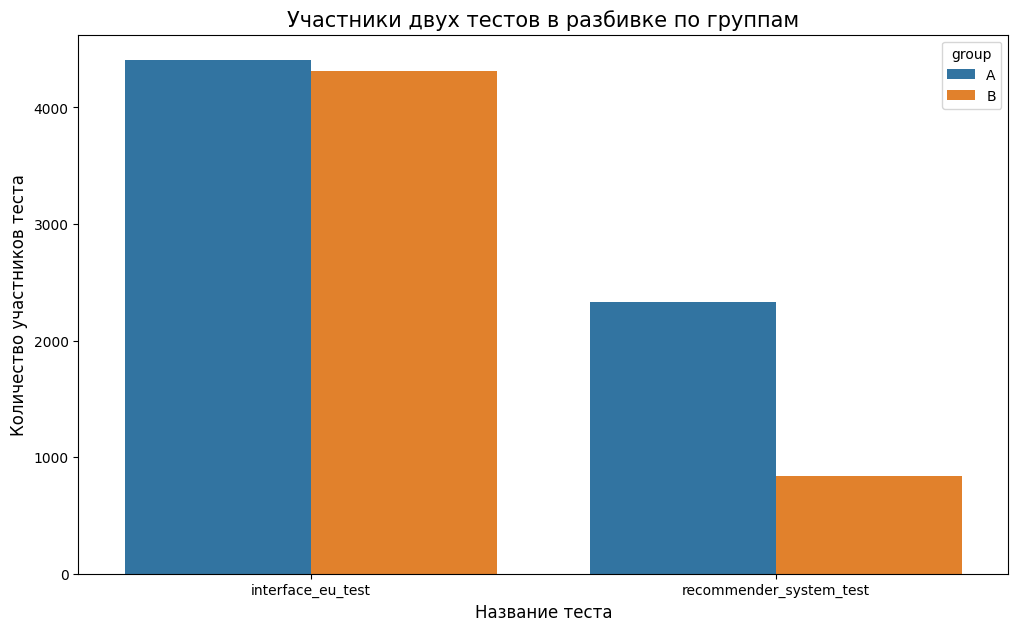

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=test_groupby.sort_values('ab_test'), x="ab_test", y="user_id", hue="group")
ax.set_xlabel('Название теста', size = 12)
ax.set_ylabel('Количество участников теста', size = 12)
ax.set_title('Участники двух тестов в разбивке по группам', size = 15)
plt.show()

Количество пользователей в группах распределено не равномерно. В группе А пользователей больше.

### Выводы по главе

В ходе проверки на соответствие ТЗ выявилось 2 проблемы: тест остановился на 5 дней раньше положенного, а общее количество пользователей слегка больше планируемого. Оба момента не столь критичны.

В целом, на данном этапе мы выяснили, что:

* Новых пользователей из EU ровно 15%, как и в ТЗ;
* Насчитывается 756 пользователей, которые попали в оба теста;
* Мы проверили в какие именно группы теста interface_eu_test попали упомянутые пользователи и выяснили, что они распределены равномерно (а это значит, что взаимосвязь двух тестов отрицать нельзя);
* Время тестирования пересекается с праздниками, но они будут одинаково влиять на наши выборки.

<a id="analysis"></a>

## Исследовательский анализ данных

### Бездействующие пользователи

Для нашего исследования важно понять, есть пользователи, которые не совершали событий. Это позволит скорректировать силу наших обобщений.

In [50]:
recommender_test_events = events.merge(recommender_test_users, on='user_id', how='inner')
recommender_test_stats = pd.DataFrame({'users': ['active', 'not_active'], 'count': [recommender_test_events['user_id'].nunique(), recommender_test_users['user_id'].nunique() - recommender_test_events['user_id'].nunique()]})

In [76]:
fig = go.Figure(data=[go.Pie(labels=recommender_test_stats['users'], values=recommender_test_stats['count'])])
fig.update_layout(title='Соотношение активных и пассивных пользователей в тесте recommender_system_test', # указываем заголовок графика
                  title_font_family='Arial',
                  width=800, # указываем размеры графика
                  height=500,
                  annotations=[dict(text='Тип значения',
                                    showarrow=False)])
fig.update_traces(marker=dict(colors=['#367a5d', '#3f405b']))
fig.show()

Мы видим, что у нас остались только активные пользователи.

### Распределение количества событий на пользователя

In [52]:
recommender_test_events = recommender_test_events.drop_duplicates()
recommender_test_events

,user_id,event_dt,event_name_x,details_x,group_x,ab_test_x,first_date_x,region,device,group_y,ab_test_y,event_dt_x,event_name_y,details_y,first_date_y,event_dt_y
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-09 02:19:17
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,A,recommender_system_test,2020-12-09 02:19:17,purchase,99.99,2020-12-07,2020-12-09 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,A,recommender_system_test,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,2020-12-09 02:19:17
3,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,A,recommender_system_test,2020-12-08 10:52:27,product_cart,NaN,2020-12-07,2020-12-09 02:19:17
4,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,A,recommender_system_test,2020-12-09 02:19:17,product_cart,NaN,2020-12-07,2020-12-09 02:19:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233423,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,B,recommender_system_test,2020-12-24 22:11:00,login,NaN,2020-12-21,2020-12-24 22:11:00
233424,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,A,interface_eu_test,2020-12-21 03:49:49,login,NaN,2020-12-21,2020-12-24 22:11:00
233425,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,A,interface_eu_test,2020-12-22 18:52:25,login,NaN,2020-12-21,2020-12-24 22:11:00
233426,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,B,recommender_system_test,2020-12-21,EU,PC,A,interface_eu_test,2020-12-24 22:11:00,login,NaN,2020-12-21,2020-12-24 22:11:00


In [53]:
recommender_test_users.groupby(['group_x']).agg({'event_name':'count', 'user_id':'nunique'})

,event_name,user_id
group_x,,
A,21369,2458
B,5287,768


In [54]:
users_events_ratio = recommender_test_users.groupby(['group_x']).agg({'event_name':'count', 'user_id':'nunique'})
users_events_ratio['events_per_user'] = round(users_events_ratio['event_name'] / users_events_ratio['user_id'], 2)

In [55]:
users_events_ratio

,event_name,user_id,events_per_user
group_x,,,
A,21369,2458,8.69
B,5287,768,6.88


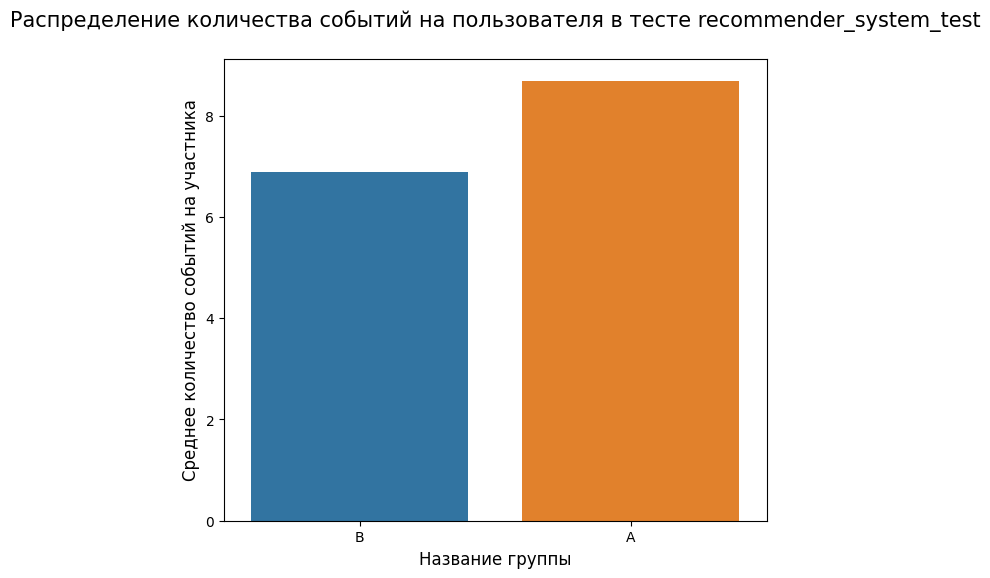

In [56]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(data=users_events_ratio.sort_values('events_per_user').reset_index(), x="group_x", y="events_per_user")
ax.set_xlabel('Название группы', size = 12)
ax.set_ylabel('Среднее количество событий на участника', size = 12)
ax.set_title('Распределение количества событий на пользователя в тесте recommender_system_test\n', size = 15)
plt.show()

Итак, количество событий на пользователя внутри теста распределено почти равномерно.

### Распределение числа событий в выборках по дням

In [57]:
recommender_test_users['date'] = recommender_test_users['event_dt_x'].dt.date

In [58]:
events_groups = events.merge(test_participants[test_participants['ab_test'] == 'recommender_system_test'],
                      how='inner',
                      on='user_id')

In [59]:
events_groups = recommender_test_users.groupby(['date', 'group_x']).agg({'event_name':'count'}).reset_index()
events_groups = events_groups.rename(columns={'event_name':'event_count'})

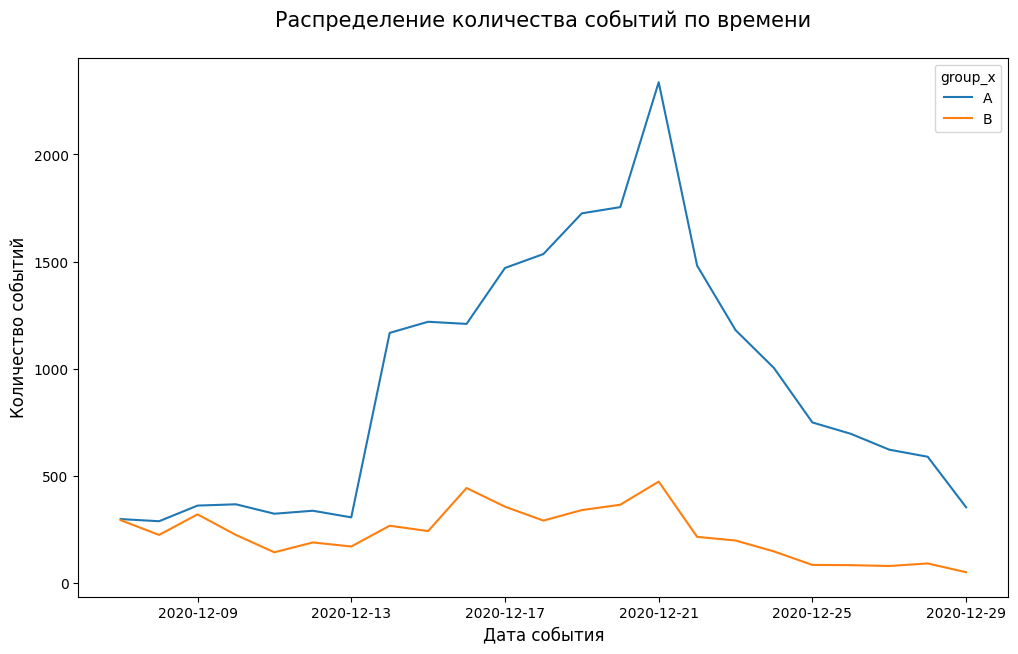

In [60]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=events_groups, y='event_count', x="date", hue='group_x')
ax.set_xlabel('Дата события', size = 12)
ax.set_ylabel('Количество событий', size = 12)
ax.set_title('Распределение количества событий по времени\n', size = 15)
plt.show();

Итак, линейный график показывает, что количество событий в группе А (контрольной) почти всегда было выше, чем в экспериментальной. Имеется момент быстрого роста количества значений: 14 декабря.

In [61]:
recommender_system_test14 = recommender_test_users.groupby(['group_x', 'first_date_x']).agg({'user_id':'nunique'})
recommender_system_test14 = recommender_system_test14.rename(columns={'user_id':'user_count'})

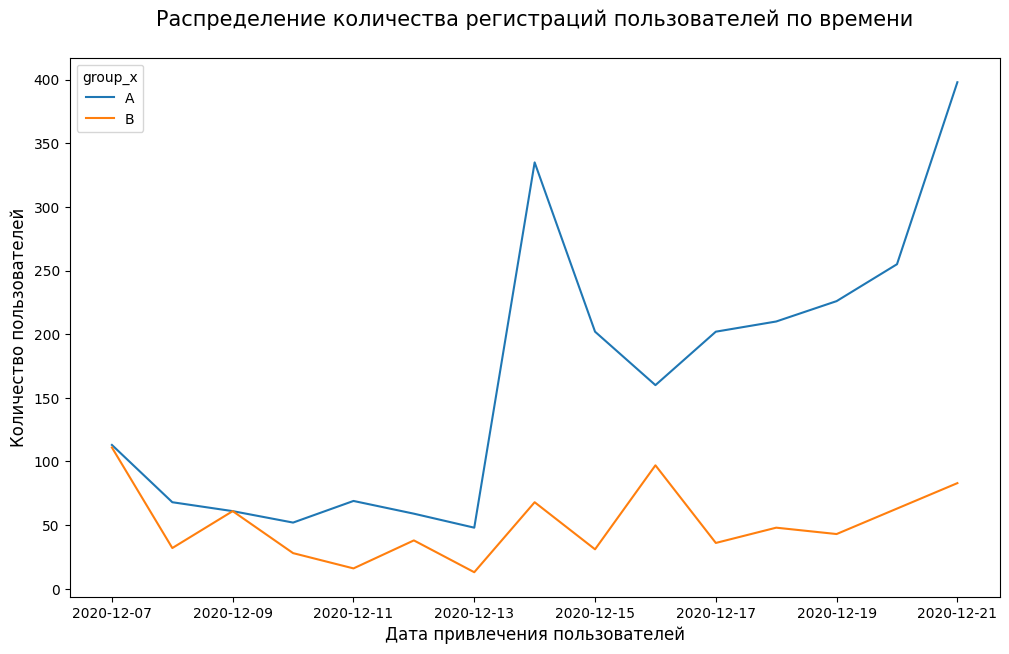

In [62]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=recommender_system_test14, y='user_count', x="first_date_x", hue='group_x')
ax.set_xlabel('Дата привлечения пользователей', size = 12)
ax.set_ylabel('Количество пользователей', size = 12)
ax.set_title('Распределение количества регистраций пользователей по времени\n', size = 15)
plt.show();

Динамика набора пользователей показывает, что скачок количества событий 14 декабря связан с притоком новых пользователей.

### Конверсия в воронке в выборках на разных этапах

In [63]:
recommender_users_events = recommender_test_users.groupby(['event_name', 'group_x']).agg({'user_id':'nunique'}).sort_values('user_id', ascending=False).reset_index()
recommender_users_events = recommender_users_events.rename(columns={'user_id':'user_count'})

In [64]:
recommender_users_events.sort_values('user_count', ascending=False)

,event_name,group_x,user_count
0,login,A,2458
1,product_page,A,1590
2,purchase,A,798
3,login,B,768
4,product_cart,A,748
5,product_page,B,432
6,purchase,B,220
7,product_cart,B,218


In [65]:
recommender_users_events['correct order'] = [1, 2, 4, 1, 3, 2, 4, 3]

In [66]:
recommender_users_events = recommender_users_events.sort_values(by=['correct order', 'user_count'])

In [67]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа A',
    y = recommender_users_events[recommender_users_events['group_x'] == 'A']['event_name'],
    x = recommender_users_events[recommender_users_events['group_x'] == 'A']['user_count'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    orientation = "h",
    y = recommender_users_events[recommender_users_events['group_x'] == 'B']['event_name'],
    x = recommender_users_events[recommender_users_events['group_x'] == 'B']['user_count'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(
    title=go.layout.Title(
        text="Конверсия в воронке <br><sup>Представлены обе выборки на разных этапах </sup>",
        xref="paper")
)

fig.show()

На основании получившейся воронки мы можем сделать следующие выводы:
* От первого этапа ко второму (просмотр карточки товара) в обеих группах переходят больше половины пользователей, но в контрольной группе этот показатель выше (65% против 56%);
* Со второго этапа пользователи могут попасть сразу на четвертый и последний этап, минуя корзину: каким-то образом можно оформить заказ и так (об этом стоит сказать в выводах)
* Переход между корзиной и оплатой также отличаются в группах: контрольная группа демонстрирует описанное выше поведение (% конверсий повышается), а вот в экспериментальной группе мы видим, что количество пользователей почти не меняется - переход осуществляется гладко,
* В любом случае, конверсия в покупку в группе А остается высокой (32% от начального числа пользователей), тогда как у группы В этот показатель чуть ниже (28% от начального числа).

### Выводы по главе. Особенности данных, которые нужно учитывать прежде чем приступать к A/B-тестированию

Повторим то, что уже было проверено на предыдущих этапах исследования:

* Мы знаем о пересечении пользователей между двумя тестами (~11% совпадает);
* Количество пользователей распределено по группам не равномерно (57% в группе А, 43% в группе В);
* Количество событий на пользователя распределено не равномерно (7 в группе А, 5.8 в группе В);
* В группе В большое число бездействующих пользователей (65% от всех бездействующих), которые никак не помогают в тестировании;
* Есть всплески большого количества событий во времени (14 и 21 декабря), но они связаны с притоком новых пользователей в выборки.

<a id="ab_test"></a>

## Оценка результатов теста

### Соответствие конверсии требованиям ТЗ

На воронке выше мы можем убедиться в том, что конверсия не соответствует заявленной в ТЗ (10% для важных событий).

### Статистическая разница долей, проверка z-критерием

Наши гипотезы. **Нулевая**: доля пользователей в группе A статистически не отличается от пользователей в группе B. **Альтернативная**: доля пользователей в группах A и B стастистически различны.

In [68]:
def z_test(successes, trials, alpha):

    # критический уровень статистической значимости
    # alpha = 0.05

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    print(successes[0] ,successes[1] ,trials[0] ,trials[1])

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
          )

Используем поправку Бонферрони из-за того, что у нас множественные сравнения.

In [69]:
alpha = 0.05
bonferroni_alpha = alpha / 3  # будет произведено три сравнения

In [70]:
stats = recommender_users_events.groupby(['event_name', 'group_x']).agg({'user_count':'sum'})

In [71]:
stats['correct order'] = [1, 1, 3, 3, 2, 2, 4, 4]

In [72]:
stats = stats.sort_values(by=['correct order', 'user_count']).reset_index()
stats

,event_name,group_x,user_count,correct order
0,login,B,768,1
1,login,A,2458,1
2,product_page,B,432,2
3,product_page,A,1590,2
4,product_cart,B,218,3
5,product_cart,A,748,3
6,purchase,B,220,4
7,purchase,A,798,4


In [73]:
# проверим разницу между выборками на этапе просмотра карточки
successes1 = [stats['user_count'][2], stats['user_count'][3]]
trials1 = [stats['user_count'][0], stats['user_count'][1]]
z_test(successes1, trials1, bonferroni_alpha)

432 1590 768 2458
p-значение:  2.4470294590850372e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [74]:
# проверим разницу между выборками на этапе просмотра корзины
successes2 = [stats['user_count'][4], stats['user_count'][5]]
trials2 = [stats['user_count'][0], stats['user_count'][1]]
z_test(successes2, trials2, bonferroni_alpha)

218 748 768 2458
p-значение:  0.27991366531430795
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [75]:
# проверим разницу между выборками на этапе оплаты
successes3 = [stats['user_count'][6], stats['user_count'][7]]
trials3 = [stats['user_count'][0], stats['user_count'][1]]
z_test(successes3, trials3, bonferroni_alpha)

220 798 768 2458
p-значение:  0.046796409172708886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Итак, только на этапе просмотра карточек между долями в наших выборках есть статистическая разница. В остальных случаях статистической разницы не обнаружено.

<a id="sum_up"></a>

## Выводы

Мы сформировали воронки для конверсии пользователей за 14 дней. Выяснилось, что пользователи могут перейти на страницу оплаты минуя остальные страницы, что в целом ненормально. Кроме того, пользователи группы А показывали лучшие результаты, а значит требования ТЗ не были выполнены.

Относительно **корректности проведения теста**. Он был выполнен с небольшими нарушениями, а значит его результатам трудно доверять на 100%. Вот основные причины:
* Набор новых пользователей проводился дольше положенного;
* Время на тест было сокращено;
* Тест проводился одновременно с другим (что в целом понятно, экономия времени и средств), но аудитории двух тестов пересекаются и не ясно, влияют ли тесты друг на друга;

Однако, учитывая всё сказанное, мы так или иначе получили интересные результаты.

**Тест следует засчитать**. Результат: новая платёжная воронка не отвечает требованиям по ТЗ.